In [1]:
import numpy as np
import scipy
from scipy import stats

import pandas as pd

import pymc3 as pm
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')
import tensorflow_probability as tfp
tfd = tfp.distributions

import arviz as az
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import ipywidgets as ipyw

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Define colors 
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

# Bayesian modeling notes

These notebooks consist of my notes, codes and solutions to exercises from the book ["Bayesian modeling and computation in Python" (Martin et al., 2022)](https://bayesiancomputationbook.com/welcome.html)


## Linear models

### Data + EDA

In [3]:
# Get penguin data
penguins = pd.read_csv('./data/penguins_size.csv')

# Drop rows with NAs
penguins = penguins.dropna(axis=0)

In [4]:
penguins.shape

(334, 7)

### Multiple regression

In [10]:
# Get observations
adelie_mass_obs = penguins[penguins.species == 'Adelie']['body_mass_g'].values
adelie_sex_obs = penguins[penguins.species == 'Adelie']['sex'].replace({'MALE': 0, 'FEMALE': 1}).values
adelie_flipper_len_obs = penguins[penguins.species == 'Adelie']['flipper_length_mm'].values

In [6]:
adelie_flipper_len_obs.mean()

190.1027397260274

In [12]:
# Model
with pm.Model() as model_adelie_flipper_reg:
    
    adelie_flipper_len = pm.Data('adelie_flipper_len', adelie_flipper_len_obs)
    
    ### Prior params ###
    # SD
    sigma = pm.HalfStudentT('sigma', 100, 2000)
    
    # Linear coefs
    beta_0 = pm.Normal('beta_0', 0, 3000)
    beta_1 = pm.Normal('beta_1', 0, 3000)
    beta_2 = pm.Normal('beta_2', 0, 3000)
    
    # Mu
    mu = pm.Deterministic(
        'mu', 
        beta_0 + beta_1 * adelie_flipper_len + beta_2 * adelie_sex_obs)
    
    
    ### Likelihood X prior ###
    mass = pm.Normal(
        'mass', 
        mu=mu,
        sigma=sigma,
        observed=adelie_mass_obs)
    
    inference_data_adelie_flipper_reg = pm.sample(return_inferencedata=True, target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_2, beta_1, beta_0, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [15]:
# Summarize
az.summary(inference_data_adelie_flipper_reg, var_names=['beta_0', 'beta_1', 'beta_2']).round(1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,865.0,769.8,-539.4,2402.2,26.1,19.5,872.0,989.0,1.0
beta_1,16.5,4.0,8.7,23.9,0.1,0.1,884.0,985.0,1.0
beta_2,-598.6,53.0,-701.8,-502.5,1.3,0.9,1646.0,1929.0,1.0


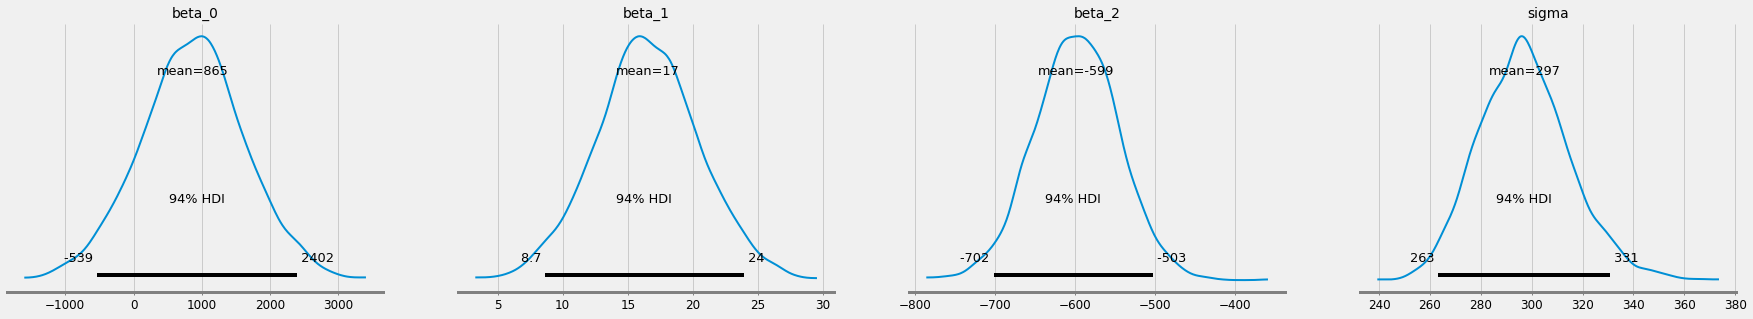

In [16]:
# Plot posterior
az.plot_posterior(
    inference_data_adelie_flipper_reg, 
    var_names=['beta_0', 'beta_1', 'beta_2', 'sigma'],
    textsize=12, 
    lw=2
)
plt.show()

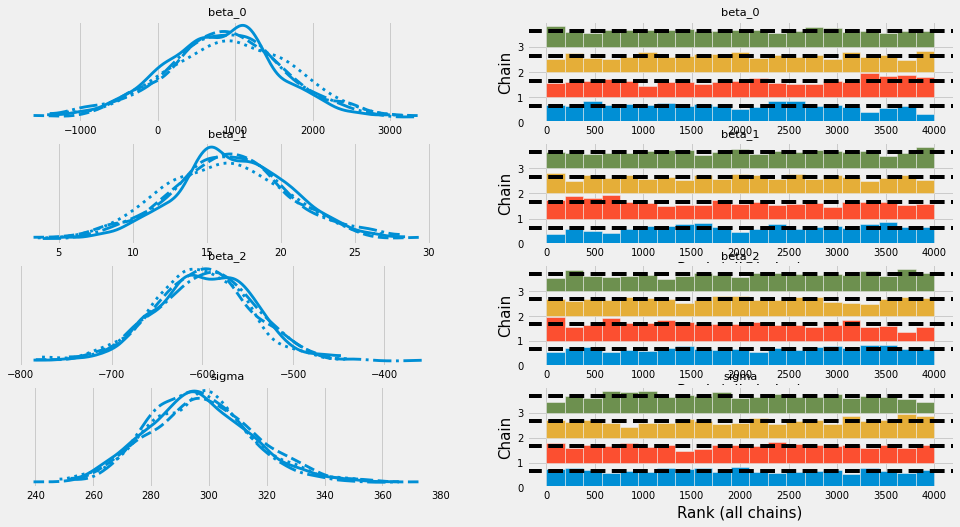

In [17]:
# Plot traces
az.plot_trace(
    inference_data_adelie_flipper_reg, 
    var_names=['beta_0', 'beta_1', 'beta_2', 'sigma'],
    compact=True, 
    figsize=(15, 8),
    divergences="bottom", 
    kind="rank_bars")
plt.show()

Chains and ranks look decent, but not perfect.

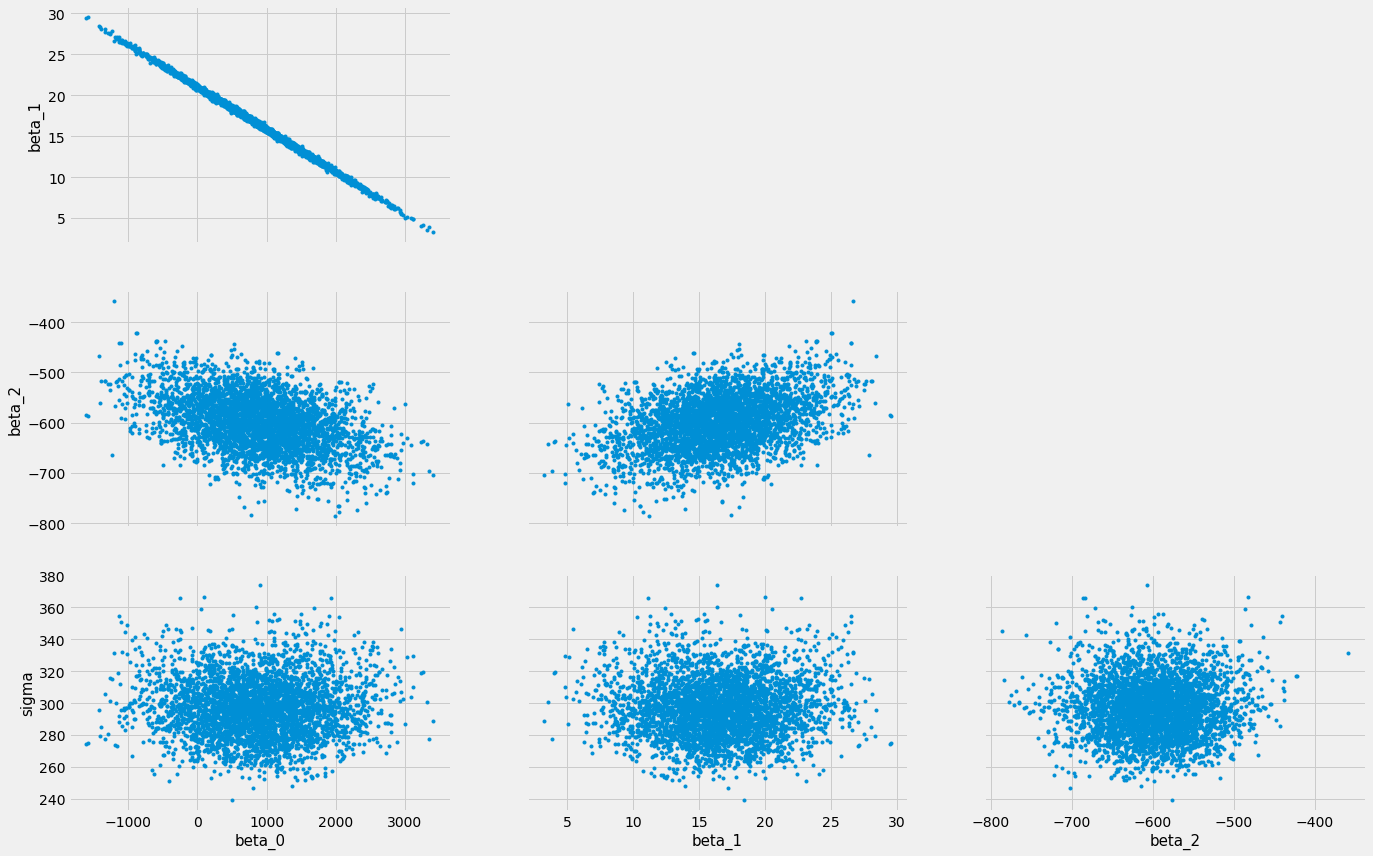

In [18]:
# Check divergences
az.plot_pair(inference_data_adelie_flipper_reg, var_names=['beta_0', 'beta_1', 'beta_2', 'sigma'], divergences=True)
plt.show()